In [1]:
## Melania Pena 
import sys
import os
import astropy.io.fits as fits
import math
import os.path
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import os.path
import matplotlib.pyplot as plt
import operator
from matplotlib.colors import LogNorm
from photutils.datasets import make_4gaussians_image
from photutils import centroid_com, centroid_1dg, centroid_2dg
import numpy as np
from astropy.visualization import PercentileInterval
from collections import deque
from photutils import fit_2dgaussian
from photutils import CircularAperture
from photutils import aperture_photometry

In [2]:
## Opening the file

## Opening a bcd file
dir_bcd ='/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1/SPITZER_I1_50037760_0000_0000_2_bcd.fits'
# dir_bcd ='/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_2/SPITZER_I2_50038016_0000_0000_2_bcd.fits'
fits_file = fits.open(dir_bcd)

## displays HDUL types within the fits file.
fits_data = get_pkg_data_filename(dir_bcd)
fits.info(fits_data)

## we take out our data from the HDU 
image_data= fits.getdata(fits_data, ext=0)

## Displays the entire info from HDU
# list_Primary = fits_file[0]
# list_Primary.header

Filename: /Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1/SPITZER_I1_50037760_0000_0000_2_bcd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     673   (32, 32, 64)   float32   


In [3]:
## pulls out specific information from data.
frame_t = fits_file[0].header['FRAMTIME']
bmjd_obs = fits_file[0].header['BMJD_OBS']
flux_conv= fits_file[0].header['FLUXCONV']
gain = fits_file[0].header['GAIN']
exp_time= fits_file[0].header['EXPTIME']

print('Frame Time:',frame_t)
print('bmjd observation:', bmjd_obs)
print('Flux Conversion',flux_conv)
print('Gain',gain)
print('Exp-time', exp_time)


Frame Time: 2.0
bmjd observation: 56781.095898
Flux Conversion 0.1257
Gain 3.7
Exp-time 1.92


In [4]:
## Creating an array for time from the given values of the file.
# i = 0
j_final = 63
list_bmjd=[]

frameday = frame_t/(3600*24)
shift_bmjd = bmjd_obs + 0.5* frameday
list_bmjd.append(shift_bmjd)

for j in range(j_final):
    value = list_bmjd[0] + (j+1)*frameday
    bmjd_arr = list_bmjd.append(value)

# print(len(list_bmjd))
# print(list_bmjd)

In [5]:
## Doing a Flux conversion
conversion_factor = gain*exp_time/flux_conv
counts_image = image_data * conversion_factor
# counts_image = image_data
# print(counts_image)
print(conversion_factor)

56.51551312649165


In [6]:
## definitions we will be using in the next cell

## slices the image into a certain amount of pixels from the total amount
def slicing_im(npix,box):
    npix = npix #total pixels
    box = box #changes the display of arrays
    result= (npix - box)/2
#     print(result)
#     print(result)
    if result % 1 == 0:
        end_num = int(result)
        strt_num = end_num
        new_st = strt_num
        new_end = npix - end_num
    else:
#         end_num = int(round(result,0))
        end_num = result +0.5
        strt_num = end_num - 1
        new_st = strt_num 
        new_end = npix - end_num
#     print("total pixels is: ",npix,'\nLeft side start by:',new_st,"\nRight side end by:",new_end)
    strt = int(new_st)
    end = int(new_end)
    return strt, end

## scales the appearance of the image
def scale_image(scale,time, data_image):
    scale_num = scale
    interval = PercentileInterval(scale_num)
    interval.get_limits(data_image[time,:,:])
    scale_array = interval(data_image[time,:,:])
    return scale_array 


In [7]:
def ifelse_pixel(image,z,x,y,Num_zxy,Num):
    if Num==31:
        if Num_zxy>Num:
            pixelpos=float('NaN')  
        else:
            pixelpos=image[z,x,y]
    elif Num==0:  
        if Num_zxy<Num:
            pixelpos=float('NaN') 
        else:
            pixelpos=image[z,x,y] 
    return(pixelpos)
def replace_nanPixels(dataIm):
    new_dataIm= np.zeros((64,32,32))
    for z in range(int(len(dataIm))):
        for x in range(int(len(dataIm)/2)):
            for y in range(int(len(dataIm)/2)):
                isitnan = math.isnan(dataIm[z,x,y])
                if isitnan == True:
    #                 print(z,x,y)
#                     print('y: ',miny,y,addy)
    #                 print('x: ',minx,x,addx)
                    addy=y+1;miny=y-1;addx=x+1;minx=x-1
    #               ------------------------
                    rightCen = ifelse_pixel(dataIm,z,x,addy,addy,31)
                    leftCen = ifelse_pixel(dataIm,z,x,miny,miny,0)
                    upCen = ifelse_pixel(dataIm,z,minx,y,minx,0)
                    downCen = ifelse_pixel(dataIm,z,addx,y,addx,31)
                    upLeft = ifelse_pixel(dataIm,z,minx,miny,minx,0)
                    upRight = ifelse_pixel(dataIm,z,minx,addy,minx,0)
                    downLeft = ifelse_pixel(dataIm,z,addx,miny,addx,31)
                    downRight = ifelse_pixel(dataIm,z,addx,addy,addy,31)
#                   ------------------------                                  
#                     print(z+1,'(',str(y+1),',',str(x+1),')')
#                     print('upleft pixel:',upLeft)
#                     print('top pixel:',upCen)
#                     print('upright pixel:',upRight)
#                     print('left pixel: ',leftCen)
#                     print('center pixel: ',im[z,x,y])
#                     print('right pixel: ',rightCen)
#                     print('lwleft pixel:',downLeft)
#                     print('bottom pixel:',downCen)
#                     print('lwright pixel:',downRight)
#                    ------------------------  
                    mean_of_c = np.nanmean([leftCen,rightCen,downLeft,downCen,downRight,upLeft,upCen,upRight])
                    new_dataIm[z,x,y] = mean_of_c  
                elif isitnan==False:
                    new_dataIm[z,x,y] = dataIm[z,x,y] 
    return new_dataIm


In [8]:
# im =image_data[:,:,:]#original data
# newarr = replace_nanPixels(im) # replaces nan pixels as the mean value of surrounding pixels
# test = np.nan_to_num(im) # replaces nan pixels as zeroes

# # compare the values
# z=0;x=0;y=3 ##First NaN value at z=0
# plt.imshow(im[0,:,:]);print(im[z,x,y]) ;plt.show()
# plt.imshow(test[0,:,:]);print(test[z,x,y]);plt.show()
# plt.imshow(newarr[0,:,:]);print(newarr[z,x,y]);plt.show()

/anaconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


3 14 17
Box Size:  3 x 3
COM:  15.203607994345925 15.183605446566368
2dG:  15.224018354909804 15.228082592859419 



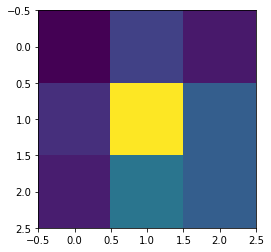

5 13 18
Box Size:  5 x 5
COM:  15.23334358450898 15.256090054477024
2dG:  15.188124738706481 15.202235525596524 



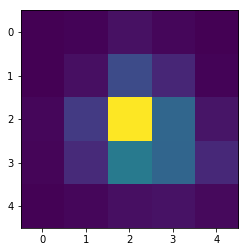

7 12 19
Box Size:  7 x 7
COM:  15.237019834194818 15.25417454501876
2dG:  15.181371174213924 15.196548587560462 



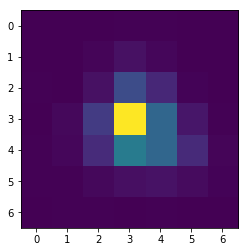

9 11 20
Box Size:  9 x 9
COM:  15.233846319041326 15.256329669048975
2dG:  15.179041027255149 15.194564366579067 



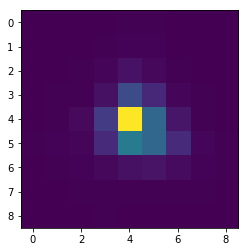

11 10 21
Box Size:  11 x 11
COM:  15.23094584035022 15.25224065238228
2dG:  15.177891432423042 15.19358326223686 



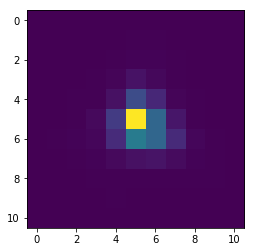

13 9 22
Box Size:  13 x 13
COM:  15.222307396857765 15.245849707642067
2dG:  15.177211276423467 15.19300240351119 



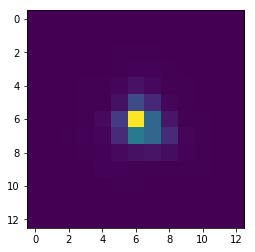

15 8 23
Box Size:  15 x 15
COM:  15.214247766353056 15.241804147599048
2dG:  15.17677821170044 15.192632508110222 



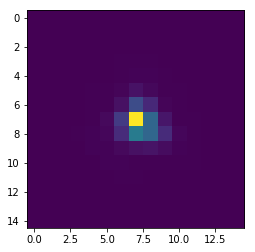

17 7 24
Box Size:  17 x 17
COM:  15.198224255747949 15.23499889099521
2dG:  15.176482703421714 15.19238007968047 



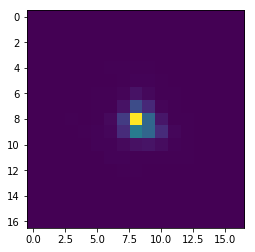

19 6 25
Box Size:  19 x 19
COM:  15.095903011610087 15.093862792107512
2dG:  15.176261805889906 15.192190651434375 



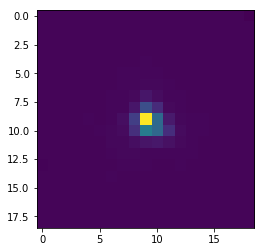

21 5 26
Box Size:  21 x 21
COM:  15.081895147051 15.080661857079955
2dG:  15.175205694977903 15.191220547611945 



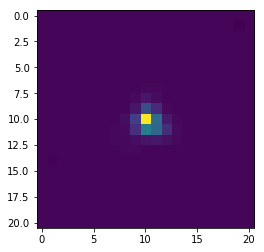

23 4 27
Box Size:  23 x 23
COM:  15.067530249871597 15.074502715952875
2dG:  15.17575248178608 15.191753176188175 



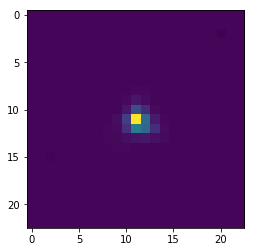

25 3 28
Box Size:  25 x 25
COM:  15.055238817593917 15.069871618912874
2dG:  15.175826173744294 15.19181818988396 



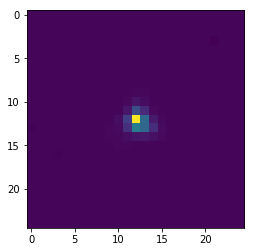

27 2 29
Box Size:  27 x 27
COM:  15.043022304275704 15.07268493526023
2dG:  15.16762252154941 15.185745065093156 



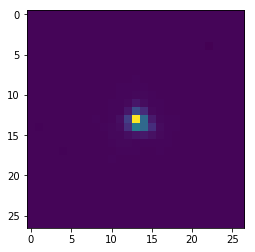

29 1 30
Box Size:  29 x 29
COM:  15.033923445206899 15.076382623279041
2dG:  15.175073150974741 15.191166465269077 



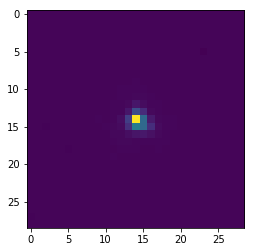

31 0 31
Box Size:  31 x 31
COM:  15.030210446561075 15.080047744392521
2dG:  15.175671303622972 15.191685825344567 



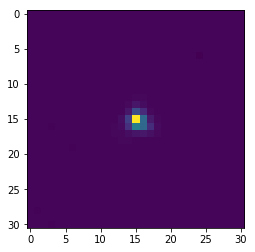

In [9]:
## This creates a for loop where it slices the image starting from it's full 
## image and measures its centroid.

time_i = 0
scale_num = 100
COM_arr_x=[]
npix = 32
start_i = 3
steps_i = 2

centroid_com_arr_x = []
centroid_com_arr_y = []
centroid_2dG_arr_x = []
centroid_2dG_arr_y = []

# counts_image=replace_nanPixels(counts_image)
# counts_image=np.nan_to_num(counts_image) 

for i_box in range(start_i,npix,steps_i):
    strt, end = slicing_im(npix,i_box)
    interval = PercentileInterval(scale_num) 
    interval.get_limits(counts_image[time_i,strt:end,strt:end])
    scale_array = interval(counts_image[time_i,strt:end,strt:end])

    result = scale_array
    if i_box < 3:
        print('too small of an imgae to calculate\n')
    elif i_box >= 3:
        x_com, y_com = centroid_com(result)
        x_2dg, y_2dg = centroid_2dg(result)
        delta = (npix-i_box)/2 -.5 #
#         print(delta)
        xc = x_com +delta#
        yc = y_com +delta#
        xc2 = x_2dg +delta#
        yc2 = y_2dg +delta#
        x_com=xc#
        y_com = yc#
        x_2dg = xc2#
        y_2dg =yc2#
        print(i_box,strt,end)
        print('Box Size: ', i_box,'x',i_box)
        print('COM: ',x_com, y_com)
        print('2dG: ',x_2dg, y_2dg,'\n')
#         ave_com = (x1+y1)/2
#         ave_2dG = (x2+y2)/2
        centroid_com_arr_x.append(x_com)
        centroid_com_arr_y.append(y_com)
        centroid_2dG_arr_x.append(x_2dg)
        centroid_2dG_arr_y.append(y_2dg)
        plt.imshow(result)
        plt.show()

In [10]:
## definitions we will be using in the next cell

##create an array where the list is set to only decimals 
def diff_arr(array):
    new_array = []
    for i in range(len(array)):
        result = array[i]-i-1
        new_array.append(result)
    return new_array

In [11]:
# cen_com_x = diff_arr(centroid_com_arr_x)
# cen_com_y = diff_arr(centroid_com_arr_y)
# cen_2dG_x = diff_arr(centroid_2dG_arr_x)
# cen_2dG_y = diff_arr(centroid_2dG_arr_y)
# # print(cen_2dG_x)

# box_size_arr = np.linspace(3,31,15)

# ## difference plot
# ## To view them individually
# # plt.plot(box_size_arr,cen_com_x,'.')
# # plt.plot(box_size_arr,cen_com_y,'.')
# # plt.plot(box_size_arr,cen_2dG_x,'.')
# # plt.plot(box_size_arr,cen_2dG_y,'.')

# ## This can will determine what box size we should use based on 
# ## the result of COM and 2dg graphs
# print('at time slice: ',time_i)

# fig = plt.figure(figsize=(10,5))
# ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# ax1.plot(box_size_arr,cen_com_x,'.',label = 'COM: x')
# ax1.plot(box_size_arr,cen_com_y,'.',label = 'COM: y')
# ax2.plot(box_size_arr,cen_2dG_x,'.',label = '2dG: x')
# ax2.plot(box_size_arr,cen_2dG_y,'.',label = '2dG: y')
# ax1.set_title('COM')
# ax2.set_title('2dG')
# ax2.legend(loc='upper right')
# ax1.legend(loc='upper right')
# plt.show
# # best used at box size 9 or 10

In [12]:
## definition we will be using in the next cell

## we will create our own definition that will return a value using
## the python photometry functions.
def aperture_sum(radius, data, val_x, val_y):
    R = radius
    val_2dg_x = val_x
    val_2dg_y = val_y
    ## for 'positions' we will take the 2dg Gaussian outputs.
    positions = [(val_2dg_x, val_2dg_y)]
    apertures = CircularAperture(positions, r=R)
    phot_table = aperture_photometry(data,apertures)
#     phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
#     print(phot_table)
    return phot_table['aperture_sum']


In [13]:
# # determining where the background becomes constant as the radius increases
# radius_arr = np.linspace(1,25,25)
# t = time_i ## Taking the same time index.

# k=0
# j=0

# ap_arr = [] ## empty aperture array
# b_arr = []  ## empty background array
# add = 200 ## we add 200 becuase some values from the background array have low negative values.
#           ## we want to see the whole log plot.
    


# for i in radius_arr: ##calculating the apertures from an array of radius vlaues ranging from 1 to 25
#     # calculating the aperture.
#     # example: aperture_sum(radius, data, val_x, val_y)
#     ap = aperture_sum(i,counts_image[t,:,:], centroid_2dG_arr_x[14], centroid_2dG_arr_y[14])
#     ap_arr.append(ap)

    
# for j in radius_arr:
#     if k ==0:
#         backgrnd = (ap_arr[1] - ap_arr[0]) / (math.pi*(radius_arr[1]**2 - radius_arr[0]**2)) 
# #         print(backgrnd)
#         backgrnd = backgrnd + add
#         k = 1+k
#         b_arr.append(backgrnd)
#     elif k > 0:
#         backgrnd = (ap_arr[k-1] - ap_arr[k]) / (math.pi*(radius_arr[k-1]**2 - radius_arr[k]**2))
# #         print(backgrnd)
#         backgrnd = backgrnd + add
#         k = 1+k
#         b_arr.append(backgrnd)


# ## Array of backgrounds when measuring the aperture by a between two radius values
# ## than calculating the background
# # print('background array as R increases:\n',b_arr)
# ## took the log of the background array

# # print(b_arr)
# plt.semilogy(radius_arr, b_arr,'.')
# plt.xlabel('radius')
# plt.ylabel('Background ')
# plt.title('Channel (logplot)')
# plt.show()
# plt.xlabel('radius')
# plt.ylabel('Background ')
# plt.title('Channel (not a logplot)')
# plt.plot(radius_arr,b_arr,'.')
# ## possible radius sizes could be from 13 to 20 (channel 1) because
# ## when looking from the resulted graph, we can
# ## guess that's where it starts to become more constant
# ## as the radius increases
# # print(ap_arr)
# # print(b_arr)


In [16]:
r_1 = 7#8
r_2 = 11#13
r_3 = 14#23

t = 0 #time index for this file
cen_i = 2 #centroid index
aperture_1 = aperture_sum(r_1,counts_image[t,:,:], centroid_com_arr_x[cen_i], centroid_com_arr_y[cen_i]) #total counts
aperture_2 = aperture_sum(r_2,counts_image[t,:,:], centroid_com_arr_x[cen_i], centroid_com_arr_y[cen_i])
aperture_3 = aperture_sum(r_3,counts_image[t,:,:], centroid_com_arr_x[cen_i], centroid_com_arr_y[cen_i])

## Area of aperture,
area_1 = math.pi * r_1**2

## Background in annulus from r_2 to r_3
background_counts = aperture_3 - aperture_2

## Area of Annulus
area_2 = math.pi*(r_3**2 - r_2**2) #also known as npix

## subtracting background: 
backgrnd_subtract = aperture_1 - background_counts*area_1/area_2

# ##background per pixel for next line below
# print(background_counts/area_2,'\n')
print('R_1: ',r_1,'\nR_2: ',r_2,'\nR_3: ',r_3)
print('\n---------------------------------------------------------------------\n')
print('with radius 1:\n',aperture_1,'\n\nwith radius 2:\n',aperture_2,'\n\nwith radius 3:\n',aperture_3,'\n')
print('\n---------------------------------------------------------------------\n')
print('area of radius one:',area_1)
print('area of radius two:',area_2,'\n')
print('\n---------------------------------------------------------------------\n')
print('background counts:\n',background_counts,'\n')

# ## our photometry will be the subtracted background variable.
print('background subtraction:\n', backgrnd_subtract)

# # So our best radius values are 7,13, and 23 for channel 1. We can still guesstimate between the 
# # radius values. But as we increase r_1 from 7 to 9, the background substraction
# # stays constant telling us that we've reached the measure of the image of the star minus the 
# # background 


R_1:  7 
R_2:  11 
R_3:  14

---------------------------------------------------------------------

with radius 1:
    aperture_sum  
-----------------
431123.5264731117 

with radius 2:
    aperture_sum   
------------------
408359.84486721805 

with radius 3:
    aperture_sum  
-----------------
372796.9766890019 


---------------------------------------------------------------------

area of radius one: 153.93804002589985
area of radius two: 235.61944901923448 


---------------------------------------------------------------------

background counts:
    aperture_sum   
------------------
-35562.86817821616 

background subtraction:
    aperture_sum  
-----------------
454357.9336828796


In [15]:
from photutils import CircularAnnulus
cen_i = 2
cenx = centroid_2dG_arr_x[cen_i]
ceny = centroid_2dG_arr_y[cen_i]
# print(cenx,ceny)
positions = [(cenx, ceny)]
apertures = CircularAperture(positions, r=7)
annulus_apertures = CircularAnnulus(positions, r_in=11., r_out=14)
# print(annulus_apertures)

apers = [apertures, annulus_apertures]
phot_table = aperture_photometry(counts_image[0,:,:], apers)
# print(phot_table)
bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
---------------------
            454377.69
